In [1]:
import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

## Baseline
Now, we will investigate the performance of different combinations of the number of ranks and the number of threads in the baseline condition.

In [3]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt


In [47]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=base

# Running setup
num_mpi=(2 3 4 6 8 12)
threads_max=(12 8 6 4 3 2)

for index in ${!num_mpi[*]}; do
    nmpi=${num_mpi[$index]}
    max_threads=${threads_max[$index]}
    echo "out = [None] * ($max_threads+1)" > out_mpi${nmpi}.txt
    for nthreads in `seq 1 $max_threads` ; do
        export OMP_NUM_THREADS=$nthreads
        ncores=$nthreads
        if [ $nthreads -gt 24 ] ; then
            ncores=24
        fi
        srun -n $nmpi -c $ncores ./stencil2d-base.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 | sed "s/data =/out[$nthreads] =/g" >> out_mpi${nmpi}.txt
    done
done

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-base.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-base.o -o stencil2d-base.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-base.x' (lite-samples) ...OK


cp stencil2d-base.x stencil2d.x


srun: Job 47967784 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 47967784


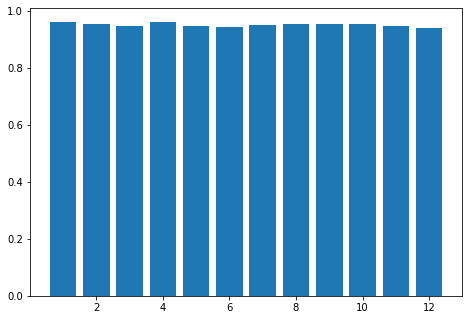

In [59]:
# Single-Plot (bar plot)
exec(open("out_mpi2.txt", "r").read())

labels = []
times = []
for i in range(len(out)):
    if i == 0:
        continue
    labels.append(i)
    times.append(out[i][:, 5].item())
    
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(labels, times)
plt.show()

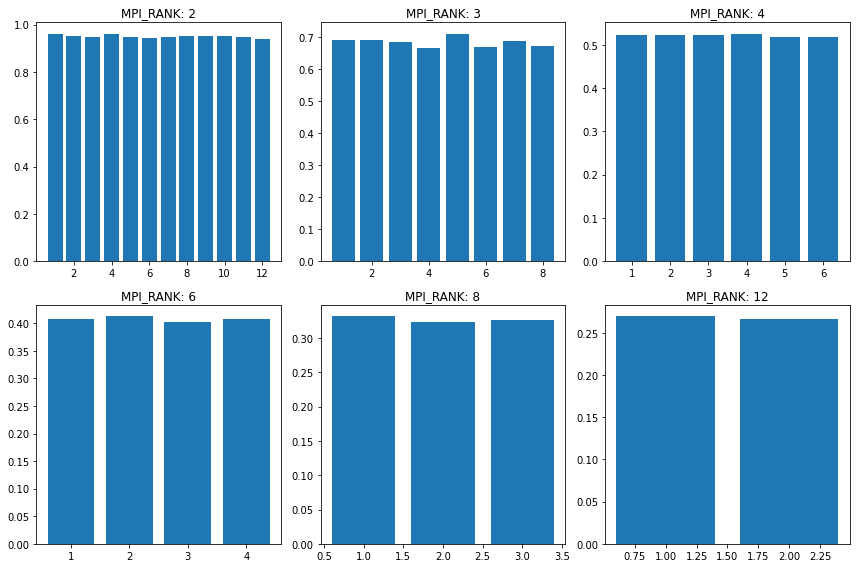

In [58]:
# Multi-Plot (bar plot)

mpi_files = ["out_mpi2.txt", "out_mpi3.txt", "out_mpi4.txt", "out_mpi6.txt", "out_mpi8.txt", "out_mpi12.txt"]
num_mpi= [2, 3, 4, 6, 8, 12]
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for idx, mpi_file in enumerate(mpi_files):
    exec(open(mpi_file, "r").read())

    labels = []
    times = []
    for i in range(len(out)):
        if i == 0:
            continue
        labels.append(i)
        times.append(out[i][:, 5].item())

    x = np.arange(len(labels))  
    width = 0.35 

    row_idx = idx // num_cols
    col_idx = idx % num_cols

    axes[row_idx, col_idx].bar(labels, times)
    axes[row_idx, col_idx].set_title("MPI_RANK: " + str(num_mpi[idx])) 

plt.tight_layout()
plt.show()

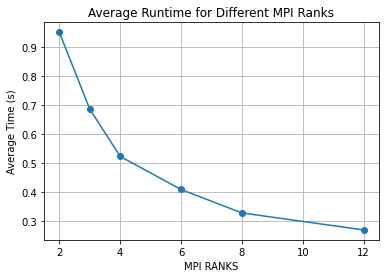

In [62]:
# line-Plot (runtime for different ranks, average of different thread results)

mpi_files = ["out_mpi2.txt", "out_mpi3.txt", "out_mpi4.txt", "out_mpi6.txt", "out_mpi8.txt", "out_mpi12.txt"]
num_mpi= [2, 3, 4, 6, 8, 12]
time_mpi = []

for idx, mpi_file in enumerate(mpi_files):
    exec(open(mpi_file, "r").read())

    labels = []
    times = []
    for i in range(len(out)):
        if i == 0:
            continue
        labels.append(i)
        times.append(out[i][:, 5].item())
    time_mpi.append(np.mean(times))
    
# plot
plt.plot(num_mpi, time_mpi, marker='o', linestyle='-')
plt.xlabel('MPI RANKS')
plt.ylabel('Average Time (s)')
plt.title('Average Runtime for Different MPI Ranks')
plt.grid(True)
plt.show()

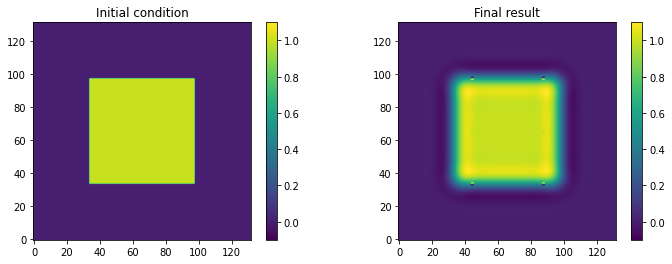

In [50]:
validate_results()

## K-Parallel

Next, we will implement k-parallel base on stencil2d-base.F90


In [65]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt


In [66]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=kparallel

# Running setup
num_mpi=(2 3 4 6 8 12)
threads_max=(12 8 6 4 3 2)

for index in ${!num_mpi[*]}; do
    nmpi=${num_mpi[$index]}
    max_threads=${threads_max[$index]}
    echo "out = [None] * ($max_threads+1)" > out_mpi${nmpi}.txt
    for nthreads in `seq 1 $max_threads` ; do
        export OMP_NUM_THREADS=$nthreads
        ncores=$nthreads
        if [ $nthreads -gt 24 ] ; then
            ncores=24
        fi
        srun -n $nmpi -c $ncores ./stencil2d-kparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 | sed "s/data =/out[$nthreads] =/g" >> out_mpi${nmpi}.txt
    done
done

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-kparallel.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-kparallel.o -o stencil2d-kparallel.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-kparallel.x' (lite-samples) ...OK


cp stencil2d-kparallel.x stencil2d.x


oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OM

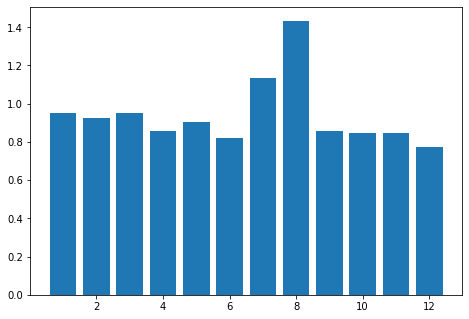

In [67]:
# Single-Plot (bar plot)
exec(open("out_mpi2.txt", "r").read())

labels = []
times = []
for i in range(len(out)):
    if i == 0:
        continue
    labels.append(i)
    times.append(out[i][:, 5].item())
    
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(labels, times)
plt.show()

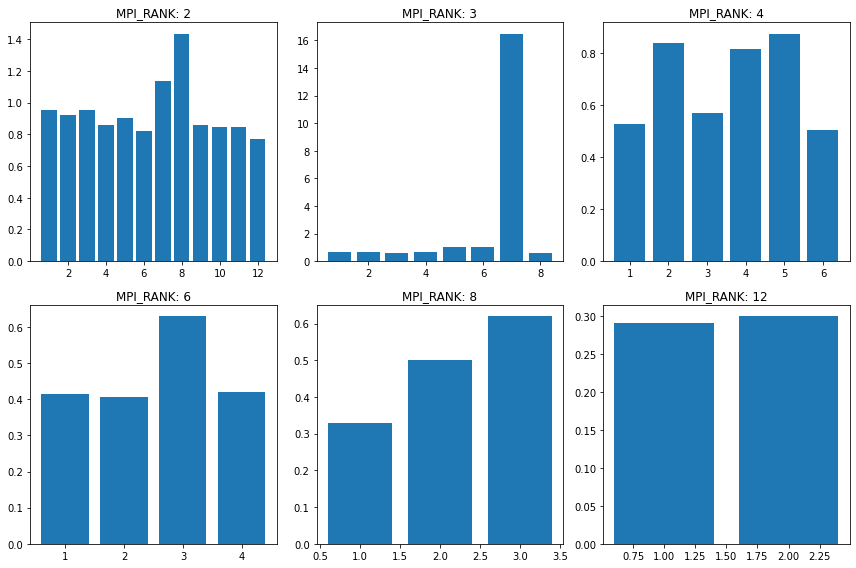

In [68]:
# Multi-Plot (bar plot)

mpi_files = ["out_mpi2.txt", "out_mpi3.txt", "out_mpi4.txt", "out_mpi6.txt", "out_mpi8.txt", "out_mpi12.txt"]
num_mpi= [2, 3, 4, 6, 8, 12]
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for idx, mpi_file in enumerate(mpi_files):
    exec(open(mpi_file, "r").read())

    labels = []
    times = []
    for i in range(len(out)):
        if i == 0:
            continue
        labels.append(i)
        times.append(out[i][:, 5].item())

    x = np.arange(len(labels))  
    width = 0.35 

    row_idx = idx // num_cols
    col_idx = idx % num_cols

    axes[row_idx, col_idx].bar(labels, times)
    axes[row_idx, col_idx].set_title("MPI_RANK: " + str(num_mpi[idx])) 

plt.tight_layout()
plt.show()

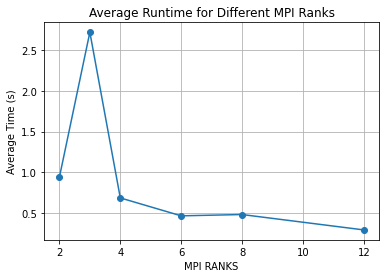

In [69]:
# line-Plot (runtime for different ranks, average of different thread results)

mpi_files = ["out_mpi2.txt", "out_mpi3.txt", "out_mpi4.txt", "out_mpi6.txt", "out_mpi8.txt", "out_mpi12.txt"]
num_mpi= [2, 3, 4, 6, 8, 12]
time_mpi = []

for idx, mpi_file in enumerate(mpi_files):
    exec(open(mpi_file, "r").read())

    labels = []
    times = []
    for i in range(len(out)):
        if i == 0:
            continue
        labels.append(i)
        times.append(out[i][:, 5].item())
    time_mpi.append(np.mean(times))
    
# plot
plt.plot(num_mpi, time_mpi, marker='o', linestyle='-')
plt.xlabel('MPI RANKS')
plt.ylabel('Average Time (s)')
plt.title('Average Runtime for Different MPI Ranks')
plt.grid(True)
plt.show()

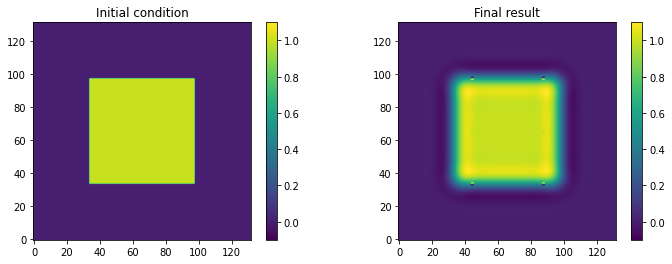

In [70]:
validate_results()

## J-parallel
Then, we will implement j-parallel base on stencil2d-base.F90

In [ ]:
%%bash
make clean

In [71]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=jparallel

# Running setup
num_mpi=(2 3 4 6 8 12)
threads_max=(12 8 6 4 3 2)

for index in ${!num_mpi[*]}; do
    nmpi=${num_mpi[$index]}
    max_threads=${threads_max[$index]}
    echo "out = [None] * ($max_threads+1)" > out_mpi${nmpi}.txt
    for nthreads in `seq 1 $max_threads` ; do
        export OMP_NUM_THREADS=$nthreads
        ncores=$nthreads
        if [ $nthreads -gt 24 ] ; then
            ncores=24
        fi
        srun -n $nmpi -c $ncores ./stencil2d-jparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 | sed "s/data =/out[$nthreads] =/g" >> out_mpi${nmpi}.txt
    done
done

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-jparallel.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-jparallel.o -o stencil2d-jparallel.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-jparallel.x' (lite-samples) ...OK


cp stencil2d-jparallel.x stencil2d.x


srun: Job 47967784 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 47967784
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print 

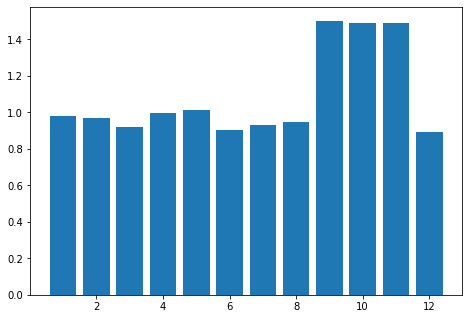

In [72]:
# Single-Plot (bar plot)
exec(open("out_mpi2.txt", "r").read())

labels = []
times = []
for i in range(len(out)):
    if i == 0:
        continue
    labels.append(i)
    times.append(out[i][:, 5].item())
    
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(labels, times)
plt.show()

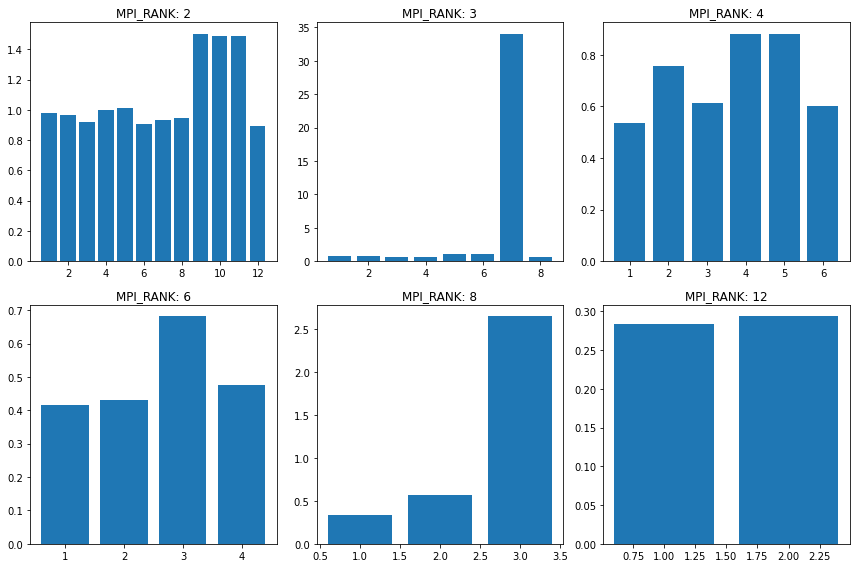

In [73]:
# Multi-Plot (bar plot)

mpi_files = ["out_mpi2.txt", "out_mpi3.txt", "out_mpi4.txt", "out_mpi6.txt", "out_mpi8.txt", "out_mpi12.txt"]
num_mpi= [2, 3, 4, 6, 8, 12]
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for idx, mpi_file in enumerate(mpi_files):
    exec(open(mpi_file, "r").read())

    labels = []
    times = []
    for i in range(len(out)):
        if i == 0:
            continue
        labels.append(i)
        times.append(out[i][:, 5].item())

    x = np.arange(len(labels))  
    width = 0.35 

    row_idx = idx // num_cols
    col_idx = idx % num_cols

    axes[row_idx, col_idx].bar(labels, times)
    axes[row_idx, col_idx].set_title("MPI_RANK: " + str(num_mpi[idx])) 

plt.tight_layout()
plt.show()

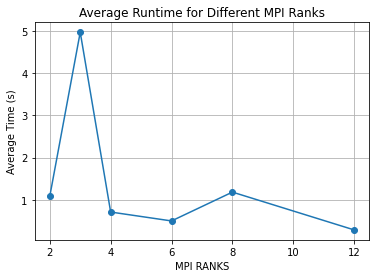

In [74]:
# line-Plot (runtime for different ranks, average of different thread results)

mpi_files = ["out_mpi2.txt", "out_mpi3.txt", "out_mpi4.txt", "out_mpi6.txt", "out_mpi8.txt", "out_mpi12.txt"]
num_mpi= [2, 3, 4, 6, 8, 12]
time_mpi = []

for idx, mpi_file in enumerate(mpi_files):
    exec(open(mpi_file, "r").read())

    labels = []
    times = []
    for i in range(len(out)):
        if i == 0:
            continue
        labels.append(i)
        times.append(out[i][:, 5].item())
    time_mpi.append(np.mean(times))
    
# plot
plt.plot(num_mpi, time_mpi, marker='o', linestyle='-')
plt.xlabel('MPI RANKS')
plt.ylabel('Average Time (s)')
plt.title('Average Runtime for Different MPI Ranks')
plt.grid(True)
plt.show()

In [ ]:
validate_results()